In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets

from dbc.main import KmeansDiscreteBayesianClassifier, KmeansDiscreteMinimaxClassifier, \
    CmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier, DecisionTreeDiscreteMinimaxClassifier
from dbc.utils import compute_conditional_risk,compute_p_hat_with_soft_labels
from sklearn.metrics import accuracy_score

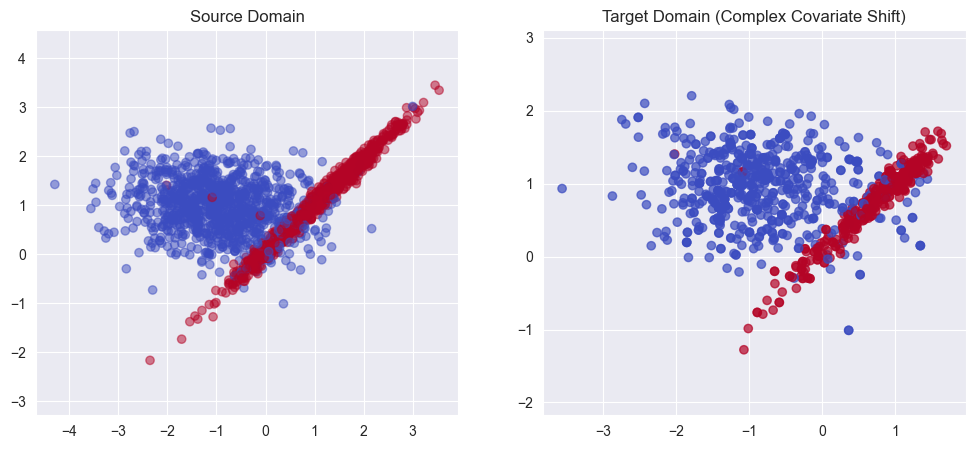

In [8]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt

# 源域数据：二维特征，二分类
X_source, y_source = make_classification(n_samples=2000, n_features=2,
                                          n_informative=2, n_redundant=0,
                                          n_clusters_per_class=1, class_sep=1,
                                          random_state=42)

# 定义更复杂的采样权重函数
def complex_sampling_weight(x):
    # 偏好：环状区域 + 斜向偏移 + 局部热点
    norm = np.linalg.norm(x)
    ring = np.exp(-((norm - 1.5)**2) / 0.2)  # 环状区域
    diagonal = np.exp(-((x[0] + x[1])**2) / 4)  # 斜对角偏移
    hotspot = np.exp(-((x[0]-1)**2 + (x[1]-1)**2) / 0.1)  # 局部热点
    return 0.4 * ring + 0.3 * diagonal + 0.3 * hotspot

# 计算每个样本的权重
weights = np.apply_along_axis(complex_sampling_weight, 1, X_source)
weights /= np.sum(weights)

# 进行加权重采样，生成目标域数据
n_target = 1000
indices = np.random.choice(np.arange(len(X_source)), size=n_target, replace=True, p=weights)
X_target = X_source[indices]
y_target = y_source[indices]

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Source Domain")
plt.scatter(X_source[:, 0], X_source[:, 1], c=y_source, cmap='coolwarm', alpha=0.5)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Target Domain (Complex Covariate Shift)")
plt.scatter(X_target[:, 0], X_target[:, 1], c=y_target, cmap='coolwarm', alpha=0.7)
plt.axis('equal')

plt.show()


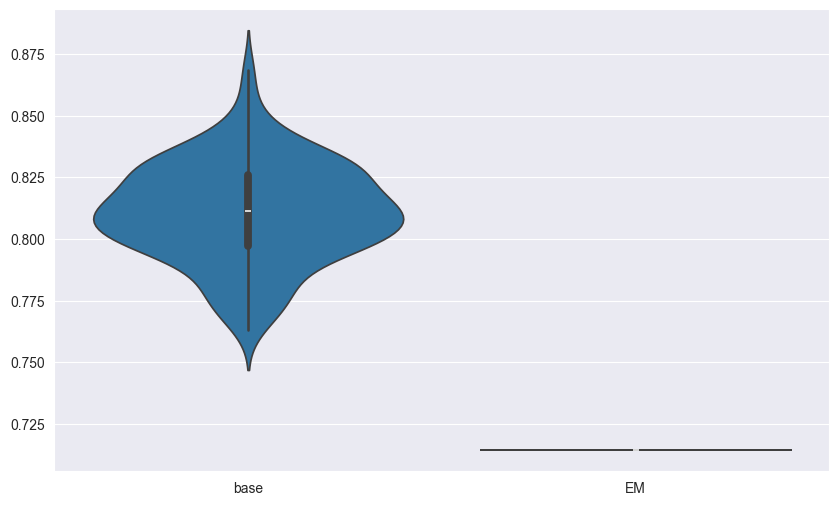

标准方法平均准确率: 0.8108 ± 0.0200
EM方法平均准确率: 0.7143 ± 0.0000


In [10]:
from sklearn.metrics import accuracy_score
import seaborn as sns

# 存储两种方法的准确率
acc_standard = []
acc_em = []

# 重复100次
for _ in range(100):
    # 重新生成数据
    # X_source, y_source = make_classification(n_samples=2000, n_features=2,
    #                                          n_informative=2, n_redundant=0,
    #                                          n_clusters_per_class=1, class_sep=1)
    #
    # # 计算权重和目标域数据
    # weights = np.apply_along_axis(complex_sampling_weight, 1, X_source)
    # weights /= np.sum(weights)
    # indices = np.random.choice(np.arange(len(X_source)), size=n_target, replace=True, p=weights)
    # X_target = X_source[indices]
    # y_target = y_source[indices]
    # Generate data
    X_source, y_source = datasets.make_blobs(n_samples=[50 * 5, 50 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True)
    X_target, y_target = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True)

    # 训练模型
    DBC_cmeans = CmeansDiscreteBayesianClassifier(n_clusters=6, fuzzifier=1.5)
    DBC_cmeans.fit(X_target, y_target)

    # 标准预测
    y_pred_standard = DBC_cmeans.predict(X_source)
    acc_standard.append(accuracy_score(y_source, y_pred_standard))

    # EM预测
    y_pred_em = np.argmax(DBC_cmeans.em(X_target, X_source, y_target)[0], axis=1)
    acc_em.append(accuracy_score(y_source, y_pred_em))

# 创建绘图数据
plot_data = {
    'base': acc_standard,
    'EM': acc_em
}

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data)

plt.show()

# 打印平均准确率
print(f'标准方法平均准确率: {np.mean(acc_standard):.4f} ± {np.std(acc_standard):.4f}')
print(f'EM方法平均准确率: {np.mean(acc_em):.4f} ± {np.std(acc_em):.4f}')
